# Image reconstruction from parallel projections

**Authors: M. Ravasi, D. Vargas, I. Vasconcelos**

Welcome to the last notebook of our **Solving large-scale inverse problems in Python with PyLops** tutorial!

The aim of this tutorial is to:

- experiment with the PyLops framework to setup non-trivial linear operators
- understand when and how to leverage third-party code in the creation of a PyLops operator
- bring everything together in a (hopefully) familiar context - that of reconstruction of an image from a limited set of projections (aka solving the *Inverse Radon transform*)

## Setting the scene

The problem of reconstructing an image from a limited set of projections is well-known problem in a variety of disciplines. Here we will specifically focus on *CT image reconstruction with parallel beam projections*.

Let's start from the **Fourier Slice Theorem** (Source: wikipedia https://en.wikipedia.org/wiki/Projection-slice_theorem):

<img src="figs/Fourier_Slice_Theorem.png" width="600">

In words, given a two-dimensional function (e.g., an image), line projections and the image's Fourier spectrum are instrinsically related:

- project a target image $\mathbf{i}$ onto lines with given slopes $\mathbf{p}$: this models the projection data that is input to the image reconstruction problem
- apply a 1D Fourier transform of the image projection for each $\mathbf{p}$
- place said 1D Fourier-domain image projections along fixed sets of $\mathbf{k}$ values onto the 2D Fourier plane, according to the orientation of the projection $\mathbf{p}$
- *or* apply a two-dimensional Fourier transform of the image (i.e., compute its wavenumber spectrum), and then extract a slice through its origin along the projection line.

Based on the fact that physically we can only acquire projections $\mathbf{p}$ - e.g., with a CT scanner - we can think about a couple of options of inverse problems for image reconstruction:

1. Simply invert the projection operator $\mathbf{P}$: $\mathbf{p} = \mathbf{P} \mathbf{i}$
1. Fourier transform the projections and place them at their right location in the wavenumber spectrum and then invert the restricted ($\mathbf{R}$) two-dimensional Fourier transform ($\mathbf{K}$): $\mathbf{k} = \mathbf{R} \mathbf{K} \mathbf{i}$

To start, taking a quickly look at what *scikit-image* has to offer (https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html). We see that they provide a forward Radon and the classical Filtered Back Projection (FBP). 

- Can we use anything to create either of our forward modelling operators and then feed them to any of PyLops solvers?
- What about the adjoint?

Let's first import the libraries we need in this tutorial

In [ ]:
# Run this when using Colab (will install the missing libraries)
# !pip install pylops scooby

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon

from pylops import FunctionOperator
from pylops.utils import dottest

We also import the famous Shepp Logan image - a well-known benchmark for this problem - which we will use in this tutorial.

Notice that we pad the Shepp Logan phantom image with zeros. We will come back to this later on in the notebook - let's not care about it for the moment.

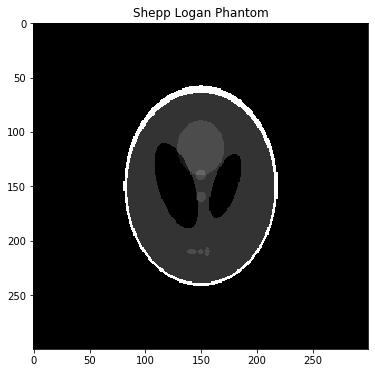

In [2]:
# Import the benchmark Shepp-Logan
image = shepp_logan_phantom()[::2, ::2]

# Zero padding
pad = 50
image = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')

plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='gray')
plt.title('Shepp Logan Phantom')
plt.axis('tight');

## scikit-image Radon

It turns out scikit-image has off-the-shelf tools for this problem...

Let's with scikit-image's ``radon`` function to see what we can do with it and also to set up a benchmark calculation.

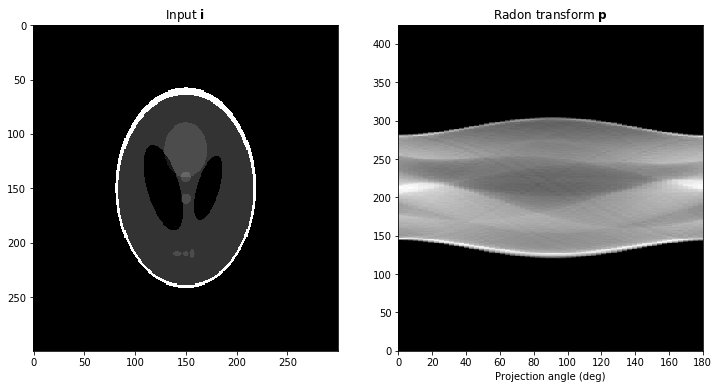

In [3]:
# Create a sampling of projection angles
thetamin, thetamax, dtheta = 0, 180, 3  
thetas = np.arange(thetamin, thetamax, dtheta)

# Calculate image projections
projection = radon(image, theta=thetas, circle=False, preserve_range=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image, cmap='gray')
ax1.set_title(r"Input $\mathbf{i}$")
ax1.axis('tight')
ax2.imshow(projection, cmap='gray', extent=(0, 180, 0, projection.shape[0]))
ax2.set_title(r"Radon transform $\mathbf{p}$")
ax2.set_xlabel("Projection angle (deg)")
ax2.axis('tight');

Ok, so going back to our projection concept, each of the Radon transform values at fixed projection angles is a discrete, separate projection at a fixed $\mathbf{p}$ - here projection angles are with respect to the horizontal axis of the image. 

Great - now we have projection data! We can the try to reconstruct our original image using ``iradon`` - scikit-images' baseline image-reconstruction routine - that is based on the well-known Filtered Back Projection (FBP) algorithm. To quatify the accuracy of this image estimate, we also compute the mean square error (MSE) of this reconstruction relative to the original image. 

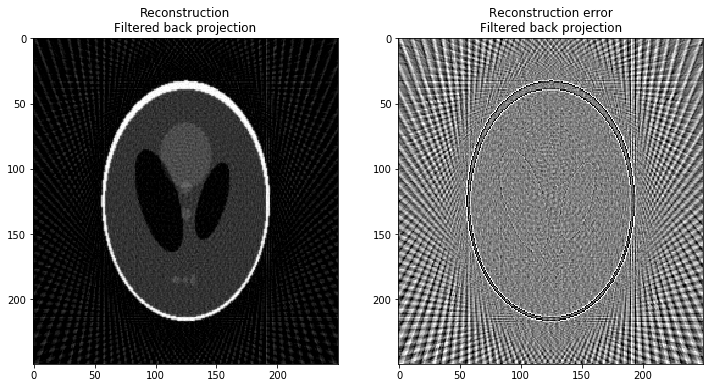

In [4]:
# Image reconstruction with scikit-image's FBP
image_fbp = iradon(projection, theta=thetas, circle=False)

# Measure its MSE
mse_fbp = np.linalg.norm(image_fbp[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.axis('tight')
ax2.imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.axis('tight');

Even if we do not know exactly what ``radon``-``iradon`` do (we just used them out-of-the-box), we wonder whether they form numerical forward-adjoint pairs, i.e., whether they pass a dot-product test... If they do, then ``radon``-``iradon`` would fit right in a PyLops operator!

One way to go about this is simply to use ``radon``-``iradon`` within a Pylops operator and see what happens... Let's try to see how can approach this using the ``FunctionOperator`` functionality in PyLops (https://pylops.readthedocs.io/en/latest/api/generated/pylops.FunctionOperator.html#pylops.FunctionOperator). We can then use our ``dottest`` to understand if this is an actual forward-adjoint pair.

In [5]:
## NOTE: using Python lambda functions is a quick-and-easy way 
##       to assign a function object to a variable.
##       We could have used def and function calls as alternative. 

# Forward function
mvec = lambda x: radon(x.reshape(image.shape), theta=thetas, circle=False, preserve_range=False)

# Adjoint function
rmvec = lambda x: iradon(x.reshape(projection.shape), theta=thetas, circle=False, filter=None, 
                         interpolation='nearest')

# Pass these to Pylop's FunctionOperator
Fop = FunctionOperator(mvec, rmvec, projection.size, image.size)

So, now we have effectively **wrapped** the ``radon``-``iradon`` *functions* into the forward and adjoint *methods* of the Pylops operator `Fop`.

**Note**: we use the filter-free version of ``iradon`` - because the filtering is not part of an explicit adjoint. 

Now, let's see what this does...

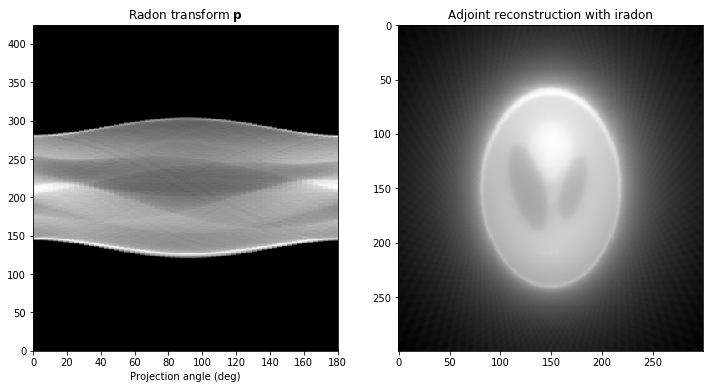

In [6]:
# First, model projections used the forward method of Fop
projection1 = Fop * image.ravel()  # note: Pylops operators act on 'vector' objects
projection1 = projection.reshape(projection.shape)   # note: Pylops operators also output 'vector' objects

# Then, apply the adjoint
image_adj = Fop.H * projection1.ravel()
image_adj = image_adj.reshape(image.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(projection, cmap='gray', extent=(0, 180, 0, projection.shape[0]))
ax1.set_title(r"Radon transform $\mathbf{p}$")
ax1.set_xlabel("Projection angle (deg)")
ax1.axis('tight')
ax2.imshow(image_adj, cmap='gray')
ax2.set_title("Adjoint reconstruction with iradon")
ax2.axis('tight');

Clearly, the ajoint-projection is different from the previous FBP result. 

It looks... OK? But, more importantly is it a **true adjoint**?

In [7]:
dottest(Fop, Fop.shape[0], Fop.shape[1])

ValueError: Dot test failed, v^T(Opu)=-235.043423 - u^T(Op^Tv)=-7.914305

Unfortunately, as we suspected it, `iradon` does not behave as the true numerical adjoint of `radon`- even without any filter options.

Nevertheless, this exercise is useful to see how we can quickly implement PyLops-compatible linear operators using ``FunctionOperator``, something that is very useful to test out ideas when prototyping in notebooks.

## Radon with PyLops

Let's see if we can use any of PyLops operators to create an operator that mimics the ``radon`` of scikit-image. Provided this is possible, we would get automatically access to the adjoint of such an operator and can solve the inverse problem with any of our solvers (including those that allow adding sparsity to the solution).

In pseudocode the projection operator (1 in figure above) is simply a rotation and summation:

``
for each theta
    rotate image by theta
    sum over horizontal axis
``

and its adjoint would be something like

``
for each theta
    spread over horizontal axis
    rotate image by -theta
``

Because rotating an image is equivalent to performing an interpolation from the original unrotated grid to a new rotated grid, we can use the PyLops ``Bilinear`` interpolation operator $\mathbf{B}$ (https://pylops.readthedocs.io/en/latest/api/generated/pylops.signalprocessing.Bilinear.html). Then, summing over horizonal lines in the new rotated grid can be easily performed using the ``Sum`` operator $\mathbf{S}$ (https://pylops.readthedocs.io/en/latest/api/generated/pylops.Sum.html). We will need to repeat it for a certain $N_\theta$ angles: this is equivalent to vertically stacking the different $\mathbf{B}$ operators at fixed $\theta_i$. In mathematical terms our projection can be written as:

$$
\mathbf{P}=
\begin{bmatrix}
    \mathbf{S} \mathbf{B}_{\theta_0}   \\
    \mathbf{S} \mathbf{B}_{\theta_1}    \\
    \vdots  \\
    \mathbf{S} \mathbf{B}_{\theta_i}    \\
    \vdots \\
    \mathbf{S} \mathbf{B}_{\theta_{N-1}} 
\end{bmatrix}
$$

First of all,  let us see how we can perform one rotation using the `Bilinear` operator. As shown in figure, we can simply identify the coordinates of each grid point after a rotation and use bilinear interpolation to interpolate the original grid into this new grid. 

Moreover, to avoid some points to fall outside of the original grid we only perform the rotation for a portion of the grid inside the original one. This is the reason we originally extended our image dimensions  -  in this case by zero padding - so the image part of interest would always be sampled under a rotation operator. 

<img src="figs/Rotated_Grid.png" width="400">

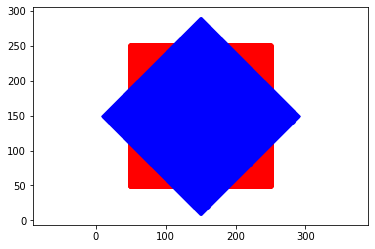

In [8]:
## Single image rotation illustration

nx, ny = image.shape
inner = 100

# define axis for rotation via bilinear interpolation
x0, y0 = nx//2, ny//2
x = np.arange(nx - inner) - x0 + inner//2
y = np.arange(ny - inner) - y0 + inner//2
X, Y = np.meshgrid(x, y, indexing='ij')
X, Y = X.ravel(), Y.ravel()
XY = np.vstack((X, Y))

# rotate
theta = 45
theta = np.deg2rad(theta)
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta), np.cos(theta)]])
XYrot = R @ XY

# recenter to positive axes
XY[0] += x0
XY[1] += y0

XYrot[0] += x0
XYrot[1] += y0

plt.figure()
plt.scatter(XY[0] , XY[1], c='r')
plt.scatter(XYrot[0], XYrot[1], c='b', s=2)
plt.axis('equal');

Create the rotation operator

In [9]:
# Pylops operator
Rop = pylops.signalprocessing.Bilinear(XYrot, dims=(nx, ny))

Rotate the image

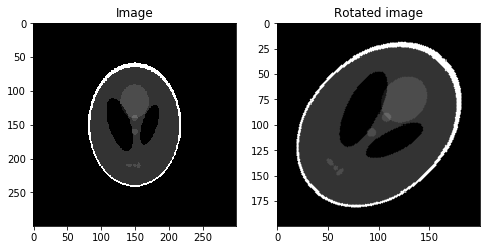

In [10]:
imagerot = Rop * image.ravel()
imagerot = imagerot.reshape(nx-inner, ny-inner)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
ax1.set_title("Image")
ax2.imshow(imagerot, cmap='gray', vmin=0, vmax=1)
ax2.set_title("Rotated image");

Let us now make an operator that applies $N_\theta$ repeated rotations and sums for all angles

In [11]:
def RadonRotate(dims, inner, thetas):
    # create original grid
    nx, ny = dims
    x0, y0 = nx//2, ny//2
    x = np.arange(nx - inner) - x0 + inner//2
    y = np.arange(ny - inner) - y0 + inner//2
    X, Y = np.meshgrid(x, y, indexing='ij')
    X, Y = X.ravel(), Y.ravel()
    XY = np.vstack((X, Y))

    thetas = np.deg2rad(thetas) # convert angles to radiants
    Rops = [] # to append operators at each angle
    for theta in thetas:
        # defined rotated coordinates
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        XYrot = R @ XY
        XYrot[0] += x0
        XYrot[1] += y0
        
        # create S*B operator for current angle
        Rops.append(pylops.Sum(dims=(nx-inner, ny-inner), dir=0) * 
                    pylops.signalprocessing.Bilinear(XYrot, dims=(nx, ny)))
    # stack all operators together
    Radop = pylops.VStack(Rops)
    return Radop

We can now create our operator.

In [12]:
inner = 100
Radop = RadonRotate((nx, ny), inner, thetas)
print(Radop)

<12000x90000 VStack with dtype=float64>


Let's now compare the projection computed before with scikit-image with our one

In [13]:
projection1 = Radop * image.ravel()
projection1 = projection1.reshape(len(thetas), ny-inner)

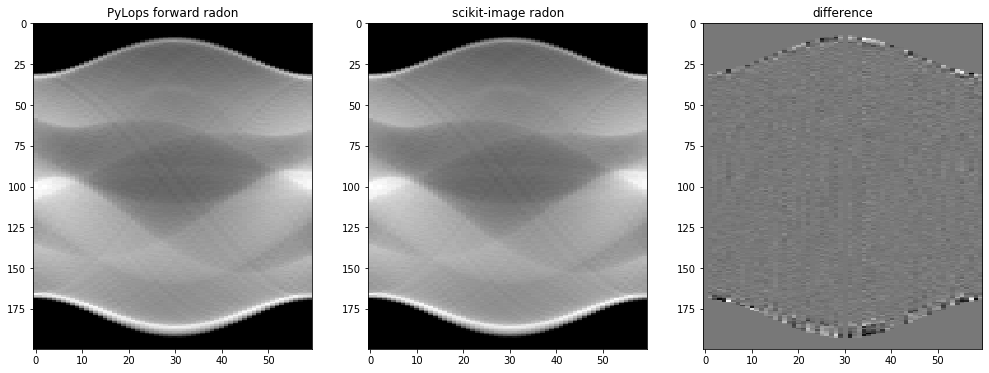

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 6))
ax1.imshow(projection1.T, cmap='gray')
ax1.set_title("PyLops forward radon")
ax1.axis("tight")
ax2.imshow(projection[projection.shape[0]//2-(nx-inner)//2:projection.shape[0]//2+(nx-inner)//2], cmap='gray')
ax2.set_title("scikit-image radon")
ax2.axis("tight")
ax3.imshow(projection1.T-projection[projection.shape[0]//2-(nx-inner)//2:projection.shape[0]//2+(nx-inner)//2], 
           cmap='gray')
ax3.set_title("difference")
ax3.axis("tight");

As you can see we have pretty much produced the same result in terms of the forward proejction operatarion, but now our operator also has a proper adjoint (i.e., satisifes the dot product test - you can verify this for yourself).

Let us see if we can now feed it into one of PyLops solvers. We will consider two cases:

- L2 regularized inversion, solving the problem that optimises: $J= ||\mathbf{p} - \mathbf{P} \mathbf{i}||_2^2 + ||\nabla \mathbf{i}||_2^2$
- TV regularized inversion, solving the problem that optimises: $J= ||\mathbf{p} - \mathbf{P} \mathbf{i}||_2^2 + ||\mathbf{D}_x  \mathbf{i}||_1 + ||\mathbf{D}_y \mathbf{i}||_1$

The first inversion can be easily carried out using PyLops ``RegularizedInversion`` (https://pylops.readthedocs.io/en/latest/api/generated/pylops.optimization.leastsquares.RegularizedInversion.html) which allows including a number of L2 regularization terms to the main functional

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 102000 rows and 90000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.062e+03  3.062e+03    1.0e+00  3.2e-02
     1  0.00000e+00   9.013e+02  9.013e+02    2.9e-01  3.7e-01   1.0e+02  1.0e+00
     2  0.00000e+00   5.495e+02  5.495e+02    1.8e-01  2.8e-01   1.2e+02  2.6e+00
     3  0.00000e+00   3.963e+02  3.963e+02    1.3e-01  2.3e-01   1.3e+02  4.2e+00
     4  0.00000e+00   2.884e+02  2.884e+02    9.4e-02  1.9e-01   1.4e+02  6.0e+00
     5  0.00000e+00   2.010e+02  2.010e+02    6.6e-02  1.8e-01   1.5e+02  8.1e+00
     6  0.00000e+00   1.552e+02  1.552e+02    5.1e-02  1.6e-01   1.5e+02  9.9e+00
     7  0.00000e+00   1.046e+02  1.046e+02    3.4e-02  1.3e-01   1.6e+02  1.2e+01
     8  0.00000e+00   6.666e+01

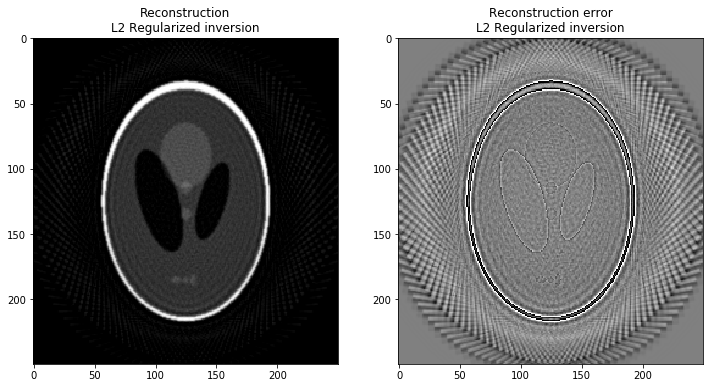

In [15]:
# Regularised LS
# Define laplacian for regularisation (i.e., smoothing)
D2op = pylops.Laplacian(dims=(nx, ny), edge=True, dtype=np.float)

# Solve inverse problem with smoothing regularisation
image_l2 = pylops.optimization.leastsquares.RegularizedInversion(Radop, [D2op], 
                                                                 projection1.ravel(), 
                                                                 epsRs=[1e0], show=True,
                                                                 **dict(iter_lim=20))
image_l2 = np.real(image_l2.reshape(nx, ny))
mse_l2 = np.linalg.norm(image_l2[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nL2 Regularized inversion")
ax1.axis('tight')
ax2.imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nL2 Regularized inversion")
ax2.axis('tight');

The second inversion will use the **Split-Bregman** solver - designed to solve L1 optimisation problems, subject to the Least-Squares fitting norm. This is an appropriate choice for the TV regularisation problem as shown above.

Split-Bregman optimization
---------------------------------------------------------
The Operator Op has 12000 rows and 90000 cols
niter_outer =   5     niter_inner =   1   tol = 1.00e-04
mu = 2.00e-01         epsL1 = [1.0, 1.0]	  epsL2 = None     
---------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1   0.00000e+00        1.064e+02        3.702e+03
     2   0.00000e+00        3.390e+01        3.602e+03
     3   0.00000e+00        7.969e+01        3.368e+03
     4   0.00000e+00        1.142e+02        2.890e+03
     5   0.00000e+00        8.937e+01        2.489e+03

Iterations = 5        Total time (s) = 54.52
---------------------------------------------------------



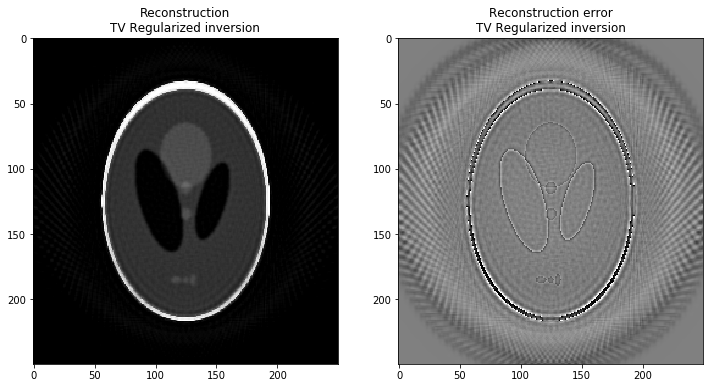

In [16]:
# TV solution with Split-Bregman solver
# Define first derivative operators
Dop = [pylops.FirstDerivative(ny*nx, dims=(nx, ny), dir=0, edge=True, kind='backward', dtype=np.float),
       pylops.FirstDerivative(ny*nx, dims=(nx, ny), dir=1, edge=True, kind='backward', dtype=np.float)]

# Solve inverse problem
mu = 0.2
lamda = [1., 1.]
niter = 5
niterinner = 1

# using Split-Bregman solver
image_tv, niter = pylops.optimization.sparsity.SplitBregman(Radop, Dop, projection1.ravel(), niter, niterinner,
                                                            mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=True,
                                                            **dict(iter_lim=10, damp=1e-2))
image_tv = np.real(image_tv.reshape(nx, ny))
mse_tv = np.linalg.norm(image_tv[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Reconstruction\nTV Regularized inversion")
ax1.axis('tight')
ax2.imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2] - image[pad//2:-pad//2, pad//2:-pad//2], 
           cmap='gray', vmin=-0.2, vmax=0.2)
ax2.set_title("Reconstruction error\nTV Regularized inversion")
ax2.axis('tight');

We can now visualize the diffferent reconstructions all together

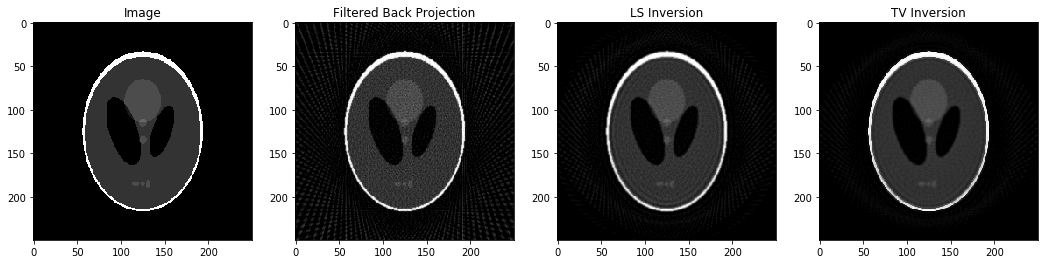

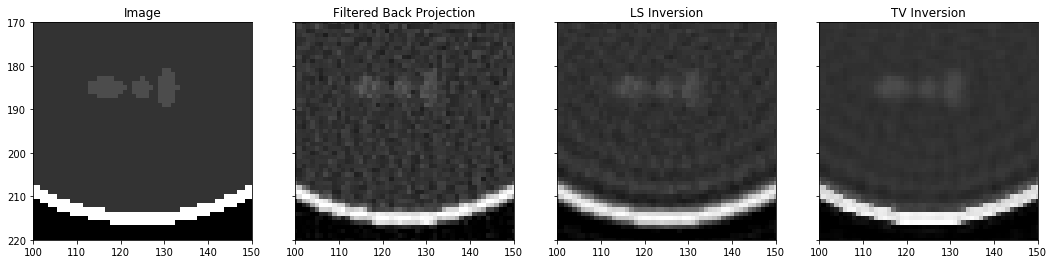

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Image')
axs[1].imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('Filtered Back Projection')
axs[2].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('LS Inversion')
axs[3].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[3].axis('tight')
axs[3].set_title('TV Inversion');

# zoomed image
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(18, 4))
axs[0].imshow(image[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[0].set_title('Image')
axs[1].imshow(image_fbp[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[1].set_title('Filtered Back Projection')
axs[2].imshow(image_l2[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')
axs[2].set_title('LS Inversion')
axs[3].imshow(image_tv[pad//2:-pad//2, pad//2:-pad//2], vmin=0, vmax=1, cmap='gray')
axs[3].axis('tight')
axs[3].set_title('TV Inversion');
axs[3].set_xlim(100, 150)
axs[3].set_ylim(220, 170);

And finally we print the Mean Squared Error (MSE) for the different reconstuctions. This is commonly as a metric for image similarity in the imaging science community.

In [18]:
print(f"FBP MSE reconstruction error: {mse_fbp:.3f}")
print(f"L2inv MSE reconstruction error: {mse_l2:.3f}")
print(f"TV MSE reconstruction error: {mse_tv:.3f}")

FBP MSE reconstruction error: 18.891
L2inv MSE reconstruction error: 14.357
TV MSE reconstruction error: 9.620


We can see that FBP is a good algorithm for this problem. Whilst being very fast it produces a reasonably accurate solution.

Our inverse based reconstructions on other hand require repeated applications of the forward and adjoint projection - thereby considerably increasing computational cost/time. However, by re-casting the reconstruction as an inverse problem we can include constraints on the solution, such as smoothness or sharpness.

When a limited number of projections is acquired, we see how L2 inversion provides already a small improvement with respect to FBP. This imporvement is mostly associated with the additional regularization terms that favour a smoother solution - i.e., by imposing a smoothness constraint.

For the TV regularized inversion we instead enforce sparsity in the first-order spatial derivatives of the solution - thus imposing a sharpness constraint. This leads to a shapr, piece-wise image which, in this case, drives the MSE down even further.

## Exercises

**EX** Try adding different regularization terms to either of the inverse problems. Can you improve the MSE further?

In [20]:
# %load -s radon_morereg solutions/radon_sol.py

**EX** Let's add now some noise to the data. How sensitive are the different methods used in this notebook to noise? Why?

In [ ]:
# %load -s radon_noise solutions/radon_sol.py

**EX** Imagine now that you have been able to perform steps 2 and 3 in the Fourier Slice theorem and have access to the subsampled wavenumber response of the Shepp Logan Phantom. How would you set up your forward model and inverse problem?

In [ ]:
# %load -s radon_kk solutions/radon_sol.py

## Recap

In this last tutorial we have learned to:

- understand how to wrap third-party code into PyLops linear operators (and evaluate their validity)
- create a fairly complex forward operator combinining several of PyLops operators
- use both L2 and sparse solvers

To conclude, we hope that this example provided you with the understanding of several of PyLops key features and its flexibility. If you find yourself having to solve large inverse problems, PyLops can help you to quickly create complex linear operators and access a wide range of solvers - *it allows you not to spend time on building the foundations but you can focus on the innovative aspects of your problem!.*

On the other hand, PyLops is not specifically built with the problem of CT tomography in mind. Whilst we showed you how it is possible to quickly create an operator to achieve this, this is far from being highly optimized for that task. In this case, note that there are much better libraries out there, e.g. ASTRA-Toolbox (https://www.astra-toolbox.com). Note that a nice exercise would be indeed to substitute our forward and backward projections with ASTRA's fast ones and subsequently leverage our solvers and  done in this notebook.

In [ ]:
scooby.Report(core='pylops')